# GPyOpt: Integrating the model hyperparameters

### Written by Javier Gonzalez and Zhenwen Dai, University of Sheffield.

## Reference Manual index

*Last updated Friday, 11 March 2016.*

Integrating the model hyperparameters of a GP is easy with GPyOpt. To see how to use this feature we start loading GPyOpt. 

In [1]:
%pylab inline  
import GPyOpt

Populating the interactive namespace from numpy and matplotlib
warning in stationary: failed to import cython module: falling back to numpy


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 21 days


We minimize the use the Six-hump camel function 

$$f(x_1,x_2) = \left(4-2.1x_1^2 = \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-3,3]\times [-2,2]$. This functions has two global minimum, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$. As in the previous case we create the function, which is already in GPyOpt. In this case we generate observations of the function perturbed with white noise of $sd=0.1$.

In [2]:
# create the object function
f_true = GPyOpt.objective_examples.experiments2d.sixhumpcamel()
f_sim = GPyOpt.objective_examples.experiments2d.sixhumpcamel(sd = 0.1)

As in previous cases we create the bounds and plot the function.

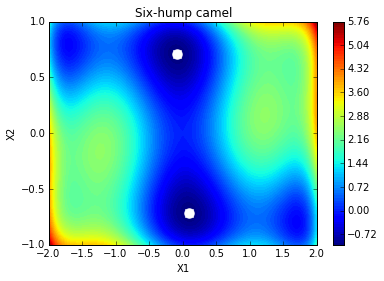

In [3]:
bounds =[{'name': 'var_1', 'type': 'continuous', 'domain': f_true.bounds[0]},
         {'name': 'var_2', 'type': 'continuous', 'domain': f_true.bounds[1]}]
f_true.plot()

In this example we are going to use **Hibrid Monte Carlo Sampling** over the parameters of the GP. If ``model_type = 'GP_MCMC'`` is selected, samples from the hyperparameters are generated when the model is updated (instead of doing the default MLE update). To  use the samples to integrate Expected improvement we need to select the option ``acquisition_type='EI_MCMC'``. Similar syntaxis works for the rest of available acquisitions.

Four parameters can be controlled in the sampling generation (apart from the hyperparameter priors that can be directly changed in the model):

* ``n_samples``: number of generated samples.
* ``n_burning ``: number of initial samples not used.
* ``subsample_interval``: interval of subsampling from HMC samples.
* ``step_size``: size of the gradient steps in the HMC sampler.
* ``leapfrog_steps``: number of gradient steps before each Metropolis Hasting step. 

All this attributes are handled as extra arguments to the ``BayesianOptimization`` class.

In [4]:
# This make take some time, in the initialization samples form the hyperparametes are generated
myBopt_mcmc = GPyOpt.methods.BayesianOptimization(f_sim.f,
                                               domain=bounds,
                                               model_type= 'GP_MCMC',
                                               acquisition_type='EI_MCMC',                                                
                                               normalize_Y = True,
                                               n_samples=50) 

** GPyOpt Bayesian Optimization class initialized succesfuly **


Now we have a look to what we have. Let's print the model first.

In [5]:
myBopt_mcmc.model.model

GP_regression.,value,constraints,priors
rbf.variance,1.1280868225,+ve,"Ga(1, 0.5)"
rbf.lengthscale,0.99485254955,+ve,"Ga(1, 0.5)"
Gaussian_noise.variance,1.11279786059,+ve,"Ga(1, 0.5)"


We see that the default priors for the hyperparameters are Gamma functions with parameters 1 and 0.5. For more details about how to change these priors have a look to [this GPy notebook](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb).

Now lets have a look to the samples that we have generated.

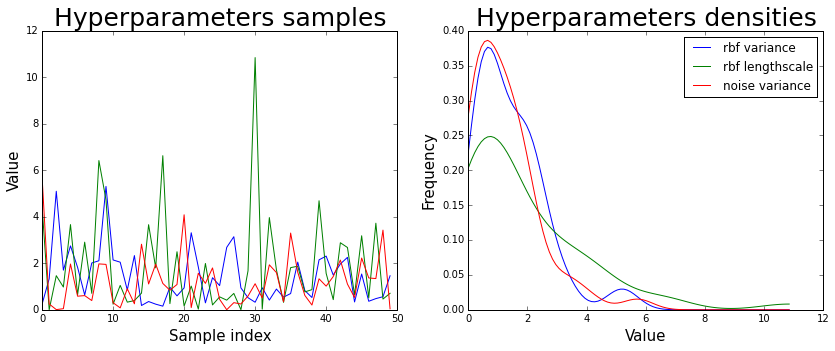

In [6]:
labels = ['rbf variance', 'rbf lengthscale','noise variance']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(myBopt_mcmc.model.hmc_samples,label = labels)
plt.title('Hyperparameters samples',size=25)
plt.xlabel('Sample index',size=15)
plt.ylabel('Value',size=15)

plt.subplot(1,2,2)
from scipy import stats
xmin = myBopt_mcmc.model.hmc_samples.min()
xmax = myBopt_mcmc.model.hmc_samples.max()
xs = np.linspace(xmin,xmax,100)
for i in xrange(myBopt_mcmc.model.hmc_samples.shape[1]):
    kernel = stats.gaussian_kde(myBopt_mcmc.model.hmc_samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()
plt.title('Hyperparameters densities',size=25)
plt.xlabel('Value',size=15)
plt.ylabel('Frequency',size=15)

To use the integrated acquisition in each iteration we simply run the optimization as usual

In [7]:
# This make take some time,
max_iter = 10  
myBopt_mcmc.run_optimization(max_iter)   

   ** Maximum number of iterations reached **


We can plot again the samples generated in the last iteration to see how the optimization affected to out beliefs about the model hyperparameters.

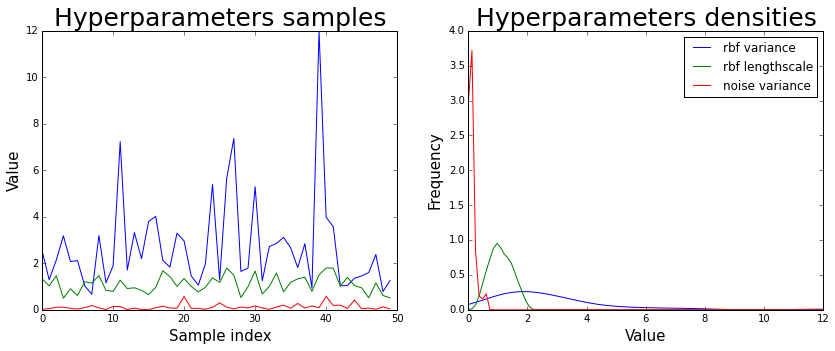

In [8]:
labels = ['rbf variance', 'rbf lengthscale','noise variance']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(myBopt_mcmc.model.hmc_samples,label = labels)
plt.title('Hyperparameters samples',size=25)
plt.xlabel('Sample index',size=15)
plt.ylabel('Value',size=15)

plt.subplot(1,2,2)
from scipy import stats
xmin = myBopt_mcmc.model.hmc_samples.min()
xmax = myBopt_mcmc.model.hmc_samples.max()
xs = np.linspace(xmin,xmax,100)
for i in xrange(myBopt_mcmc.model.hmc_samples.shape[1]):
    kernel = stats.gaussian_kde(myBopt_mcmc.model.hmc_samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()
plt.title('Hyperparameters densities',size=25)
plt.xlabel('Value',size=15)
plt.ylabel('Frequency',size=15)

And, of course, you can check how the optimization evolved when you integrate out the acquisition.

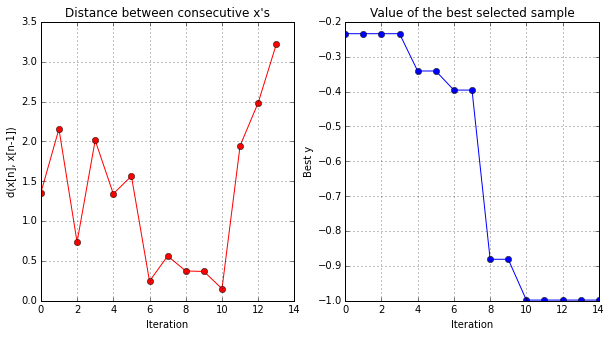

In [9]:
myBopt_mcmc.plot_convergence()